In [52]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.basic_cleaning import *
from functions.pipeline_helpers import *

In [53]:
train_data = pl.read_csv("train_data.csv").pipe(reduce_memory_usage)
test_data = pl.read_csv("test_data.csv").pipe(reduce_memory_usage)
train_data.shape,test_data.shape

((5611, 19), (1406, 19))

In [54]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

In [55]:
for col in cat_cols[:-1]:
    train_data=train_data.with_columns(train_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))
    test_data=test_data.with_columns(test_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))

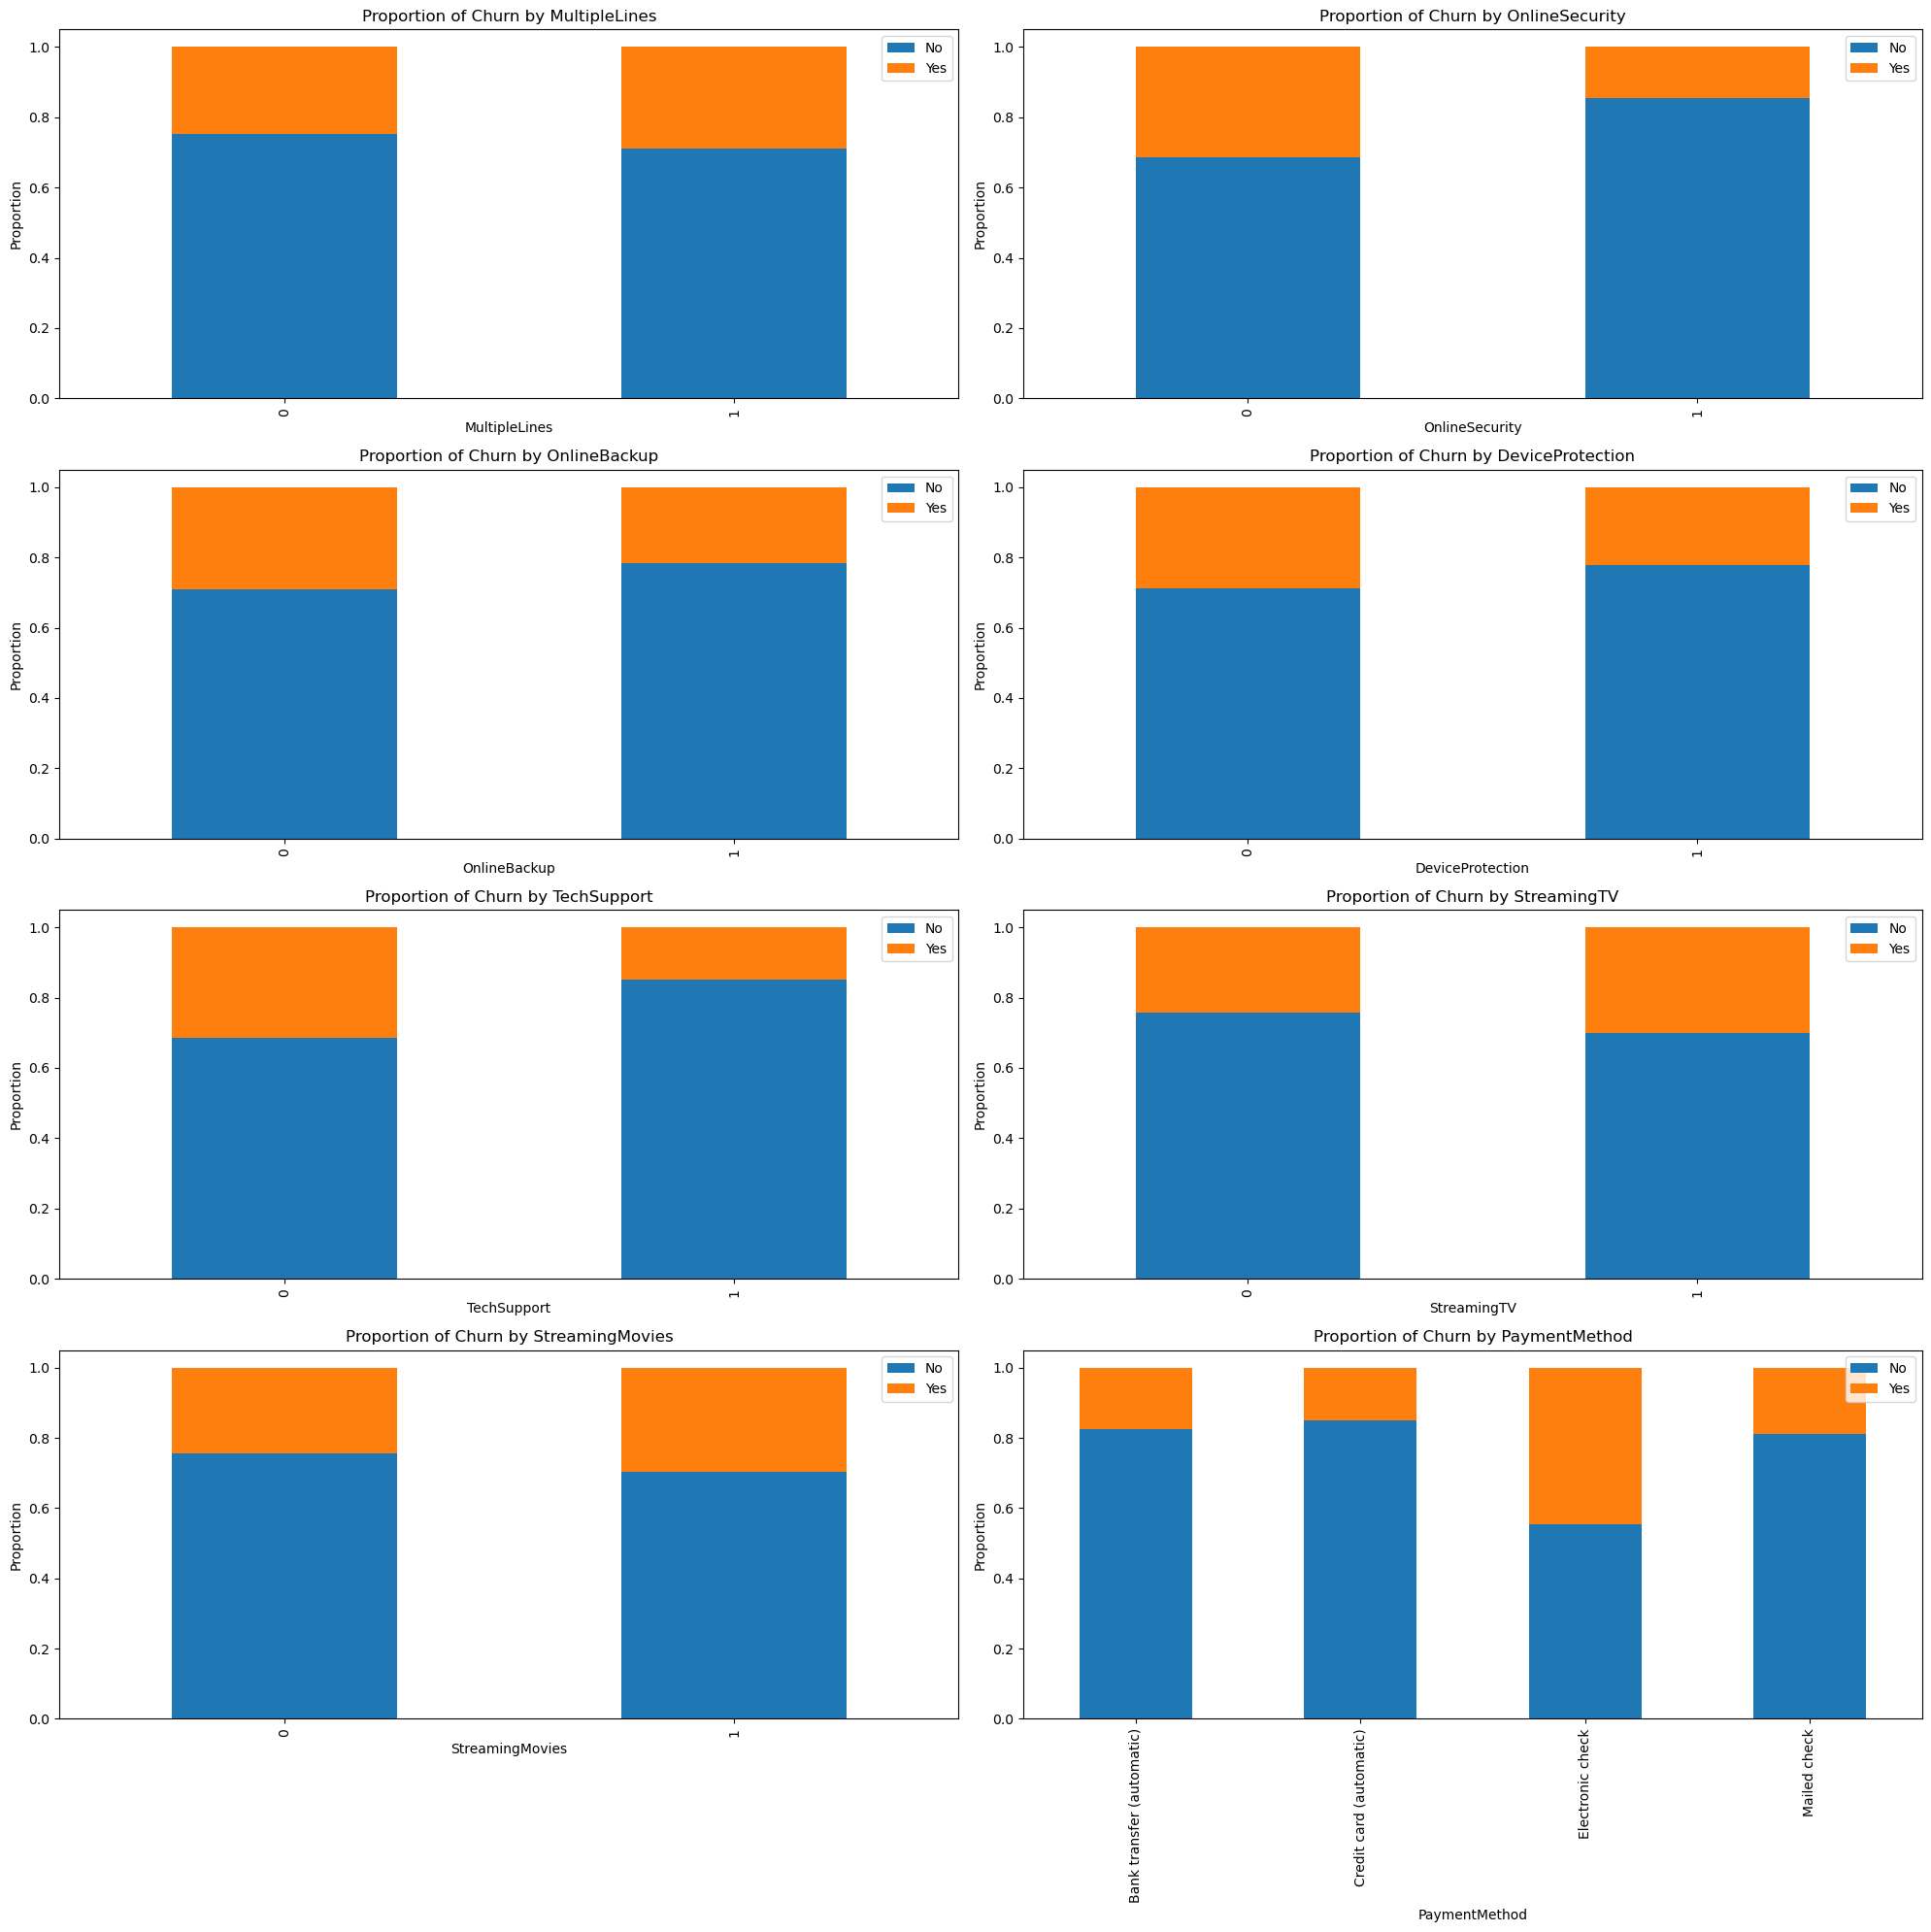

In [56]:
cat_proportion_plot(train_data,cat_cols,"Churn")

In [57]:
train_data=train_data.with_columns(train_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")
test_data=test_data.with_columns(test_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")

In [58]:
train_data=train_data.with_columns(pl.Series((train_data["StreamingMovies"] | train_data["StreamingTV"])).alias("Streamer")).drop("StreamingMovies","StreamingTV")
train_data=train_data.with_columns(pl.Series(train_data["OnlineSecurity"] | train_data["DeviceProtection"] | train_data['OnlineBackup']).alias("Safer")).drop("OnlineSecurity","DeviceProtection","OnlineBackup")
train_data=train_data.with_columns(pl.Series(train_data['Partner'] & train_data['Dependents']).alias("Family")).drop("Partner","Dependents")
train_data=train_data.with_columns(pl.Series(train_data['PaperlessBilling'] & train_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
train_data=train_data.with_columns(pl.Series(train_data["Safer"] & train_data['Family']).alias("saferAndFamily"))


test_data=test_data.with_columns(pl.Series((test_data["StreamingMovies"] | test_data["StreamingTV"])).alias("Streamer")).drop("StreamingMovies","StreamingTV")
test_data=test_data.with_columns(pl.Series(test_data["OnlineSecurity"] | test_data["DeviceProtection"] | test_data['OnlineBackup']).alias("Safer")).drop("OnlineSecurity","DeviceProtection","OnlineBackup")
test_data=test_data.with_columns(pl.Series(test_data['Partner'] & test_data['Dependents']).alias("Family")).drop("Partner","Dependents")
test_data=test_data.with_columns(pl.Series(test_data['PaperlessBilling'] & test_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
test_data=test_data.with_columns(pl.Series(test_data["Safer"] & test_data['Family']).alias("saferAndFamily"))

In [59]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

Non Binary Features

In [60]:
non_binary_cols=[col for col in num_cols if len(train_data[col].unique())>2]
binary_cols=[col for col in num_cols if len(train_data[col].unique())==2]
non_binary_cols

['tenure', 'InternetService', 'Contract', 'MonthlyCharges', 'TotalCharges']

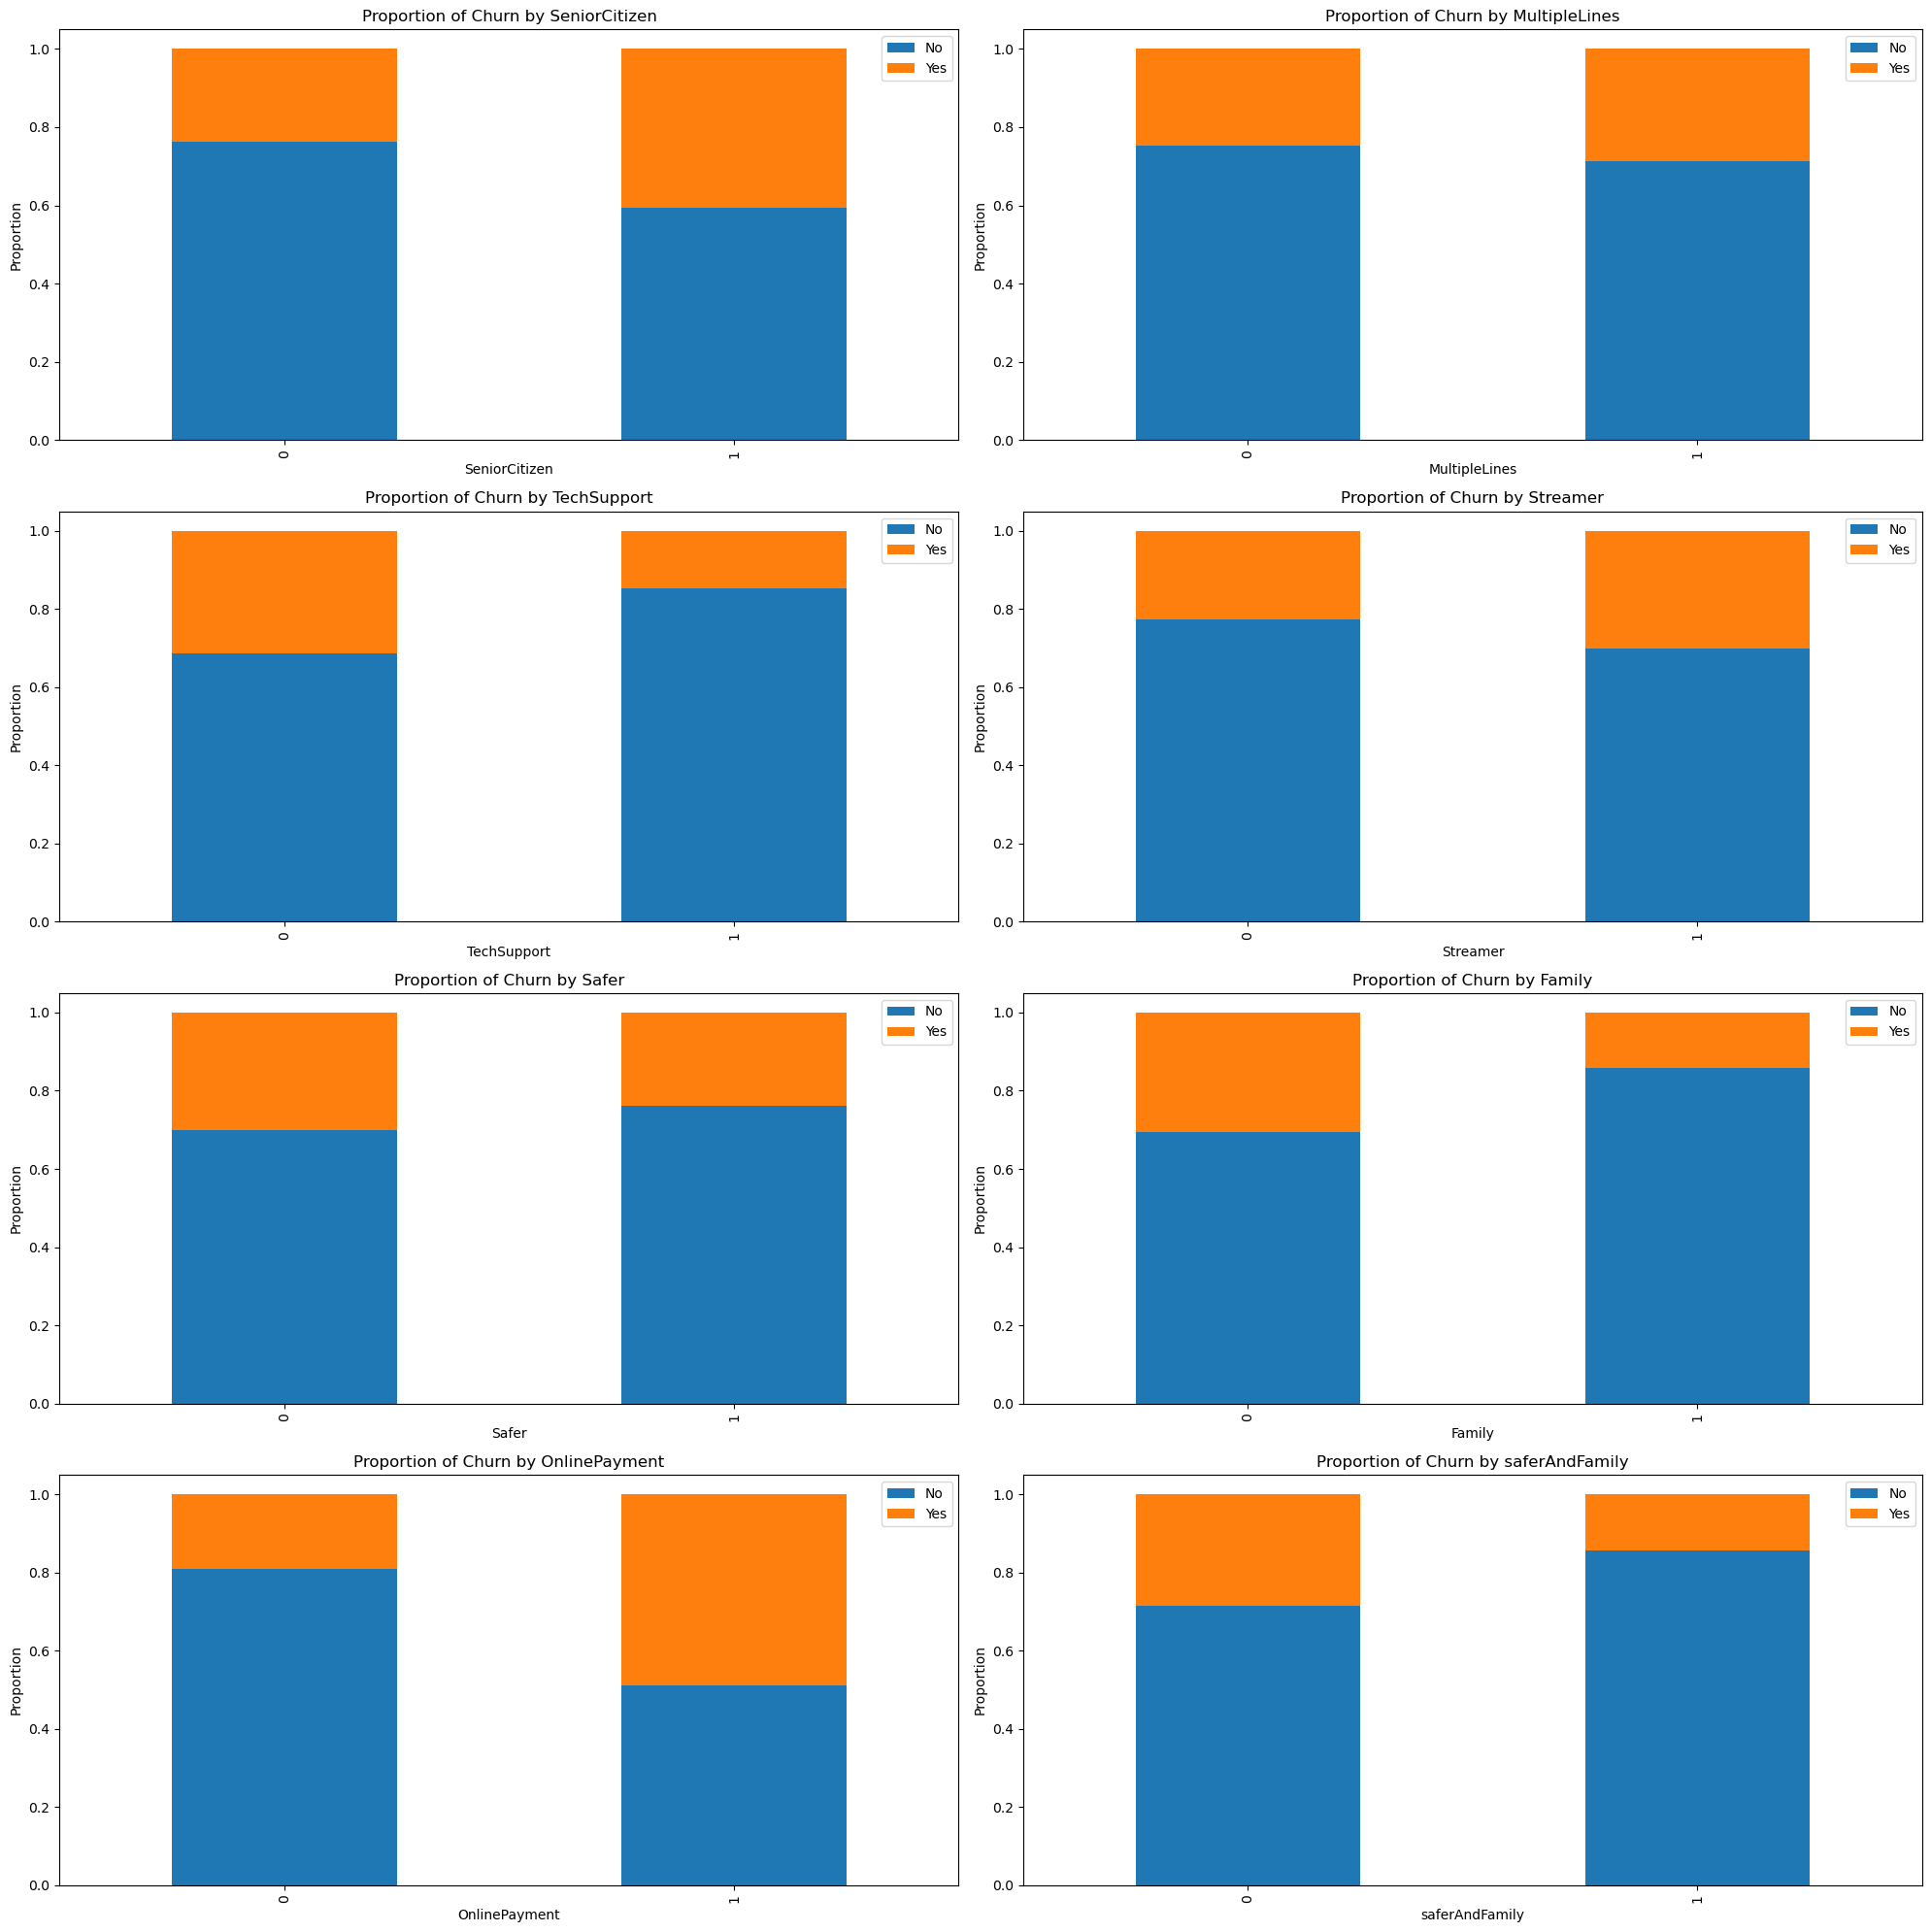

In [61]:
cat_proportion_plot(train_data,binary_cols,"Churn")

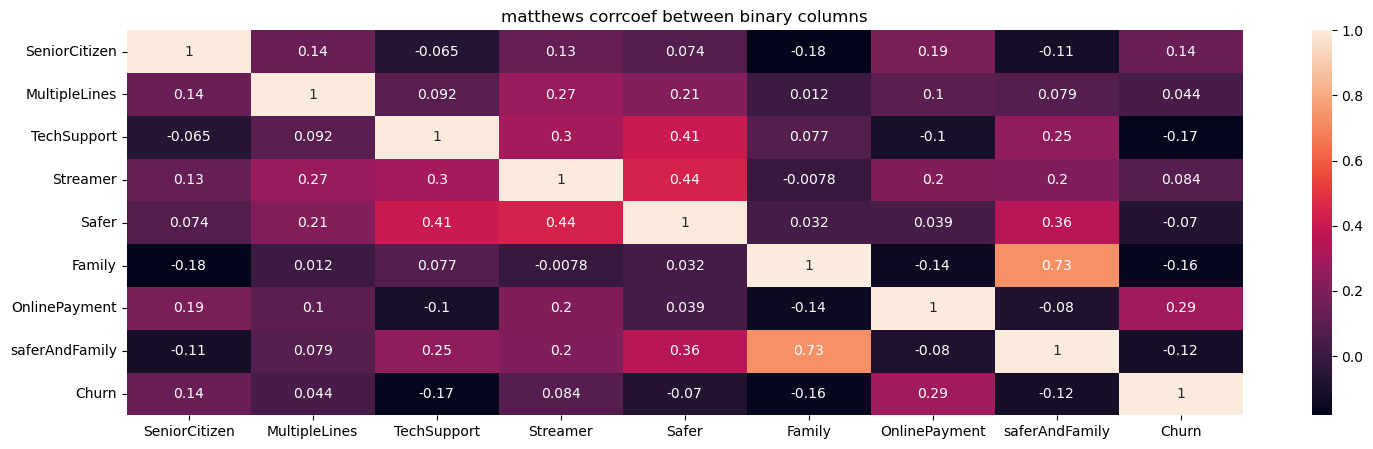

In [62]:
plot_binarycols_heatmap(train_data,binary_cols+["Churn"])

In [63]:
perform_non_normal_kruskal_hypothesis(train_data,binary_cols,"Churn")

Kruskal-Wallis H-statistic: 112.26302393135892 P-value: 3.129174828213605e-26
There is a significant difference in Churn between different SeniorCitizen categories.

Kruskal-Wallis H-statistic: 11.075320207648032 P-value: 0.0008748431125606774
There is a significant difference in Churn between different MultipleLines categories.

Kruskal-Wallis H-statistic: 162.88401068728797 P-value: 2.65192216302243e-37
There is a significant difference in Churn between different TechSupport categories.

Kruskal-Wallis H-statistic: 39.69648142814831 P-value: 2.9665948978105707e-10
There is a significant difference in Churn between different Streamer categories.

Kruskal-Wallis H-statistic: 27.53503890925733 P-value: 1.5427411958174644e-07
There is a significant difference in Churn between different Safer categories.

Kruskal-Wallis H-statistic: 143.22203862855636 P-value: 5.256340383575236e-33
There is a significant difference in Churn between different Family categories.

Kruskal-Wallis H-statistic:

In [64]:
# from sklearn.cluster import KMeans
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler,OneHotEncoder

# cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
# num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

# X_train=train_data.drop("customerID","Churn").to_pandas()
# y_train=train_data["Churn"].to_pandas()
# X_test=test_data.drop("customerID","Churn").to_pandas()
# y_test=test_data["Churn"].to_pandas()

# transformer = ColumnTransformer(
#     [
#         ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
#         ("scaler", StandardScaler(), num_cols)
#      ],
#     remainder="passthrough",
# )
# kmeans_pipe = Pipeline(
#     [
#         ("tranformer", transformer),
#         ("classifier", KMeans(n_clusters=3,random_state=42)),
#     ]
# )
# kmeans_pipe
# kmeans_pipe.fit(X_train)
# # Evaluation
# train_clusters=kmeans_pipe.predict(X_train)
# test_clusters=kmeans_pipe.predict(X_test)
# train_data=train_data.with_columns(pl.Series(train_clusters).alias("Cluster"))
# test_data=test_data.with_columns(pl.Series(test_clusters).alias("Cluster"))

# Multivariate Analysis

In [65]:
# sns.pairplot(train_data[non_binary_cols+["Cluster","Churn"]].to_pandas(),hue='Churn',y_vars="Cluster")

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

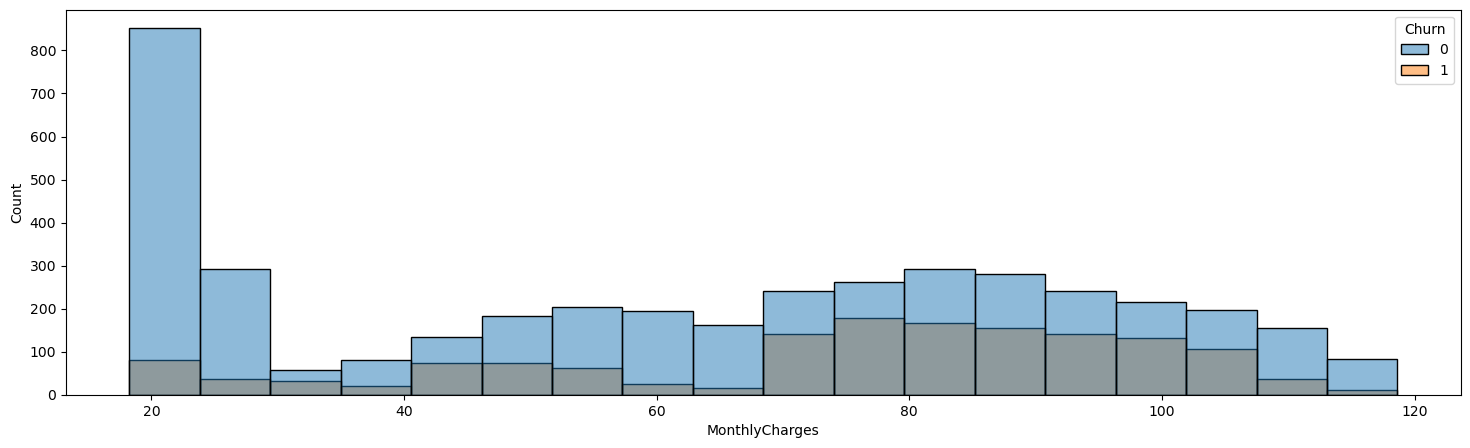

In [66]:
plt.figure(figsize=(18,5))
sns.histplot(train_data,x="MonthlyCharges",hue="Churn")

In [67]:
train_data=train_data.with_columns(train_data["MonthlyCharges"].is_between(70,110).cast(pl.Int8).alias("MonthlyChargesBin"))
test_data=test_data.with_columns(test_data["MonthlyCharges"].is_between(70,110).cast(pl.Int8).alias("MonthlyChargesBin"))

In [68]:
calculate_vif(train_data,"Churn",head=8)

,variables,VIF
0,const,130.522343
7,MonthlyCharges,25.782672
4,InternetService,11.519056
8,TotalCharges,10.804876
2,tenure,7.440640
13,saferAndFamily,2.938431
14,MonthlyChargesBin,2.726339
11,Family,2.691126


In [69]:
# train_data=train_data.drop("MonthlyCharges")
# test_data=test_data.drop("MonthlyCharges")
# calculate_vif(train_data,"Churn",head=8)

In [70]:
train_data.write_csv("../Day4_ClassBalancing/train_featureEngineered.csv")
test_data.write_csv("../Day4_ClassBalancing/test_featureEngineered.csv")
train_data.write_csv("../Day7_AutoMl/train_featureEngineered.csv")
test_data.write_csv("../Day7_AutoMl/test_featureEngineered.csv")

In [71]:
train_data.sample(5)

customerID,SeniorCitizen,tenure,MultipleLines,InternetService,TechSupport,Contract,MonthlyCharges,TotalCharges,Churn,Streamer,Safer,Family,OnlinePayment,saferAndFamily,MonthlyChargesBin
str,i8,i8,i8,i8,i8,i8,f32,f32,i8,i8,i8,i8,i8,i8,i8
"""5456-ITGIC""",1,72,0,1,1,24,64.449997,4641.100098,0,1,1,0,0,0,0
"""4112-LUEIZ""",0,10,0,0,0,1,89.5,863.099976,1,1,0,0,1,0,1
"""9526-BIHHD""",0,1,0,1,0,1,29.700001,29.700001,1,0,1,0,0,0,0
"""3612-YVGSJ""",0,71,1,2,0,24,24.450001,1681.599976,0,0,0,0,0,0,0
"""9681-KYGYB""",1,49,1,0,0,1,88.199997,4159.450195,0,0,1,0,1,0,1


In [72]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2648369274639102

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ('select',SelectKBest(k=10)),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment',
                                                   'saferAndFamily',
                                                   'MonthlyChargesBin'])])),
                ('select', SelectKBest()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.648369274639102}))])

In [74]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

Mean Train roc auc Score: 0.8399224182623622
Mean Train recall Score: 0.7909150620546858

Mean Test roc auc Score: 0.8385917398695526
Mean Test recall Score: 0.7893701251587159


Recall score: 0.82
Correlation : 0.4973034302390399
Classification Report 
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1031
           1       0.53      0.82      0.64       375

    accuracy                           0.76      1406
   macro avg       0.72      0.78      0.73      1406
weighted avg       0.81      0.76      0.77      1406



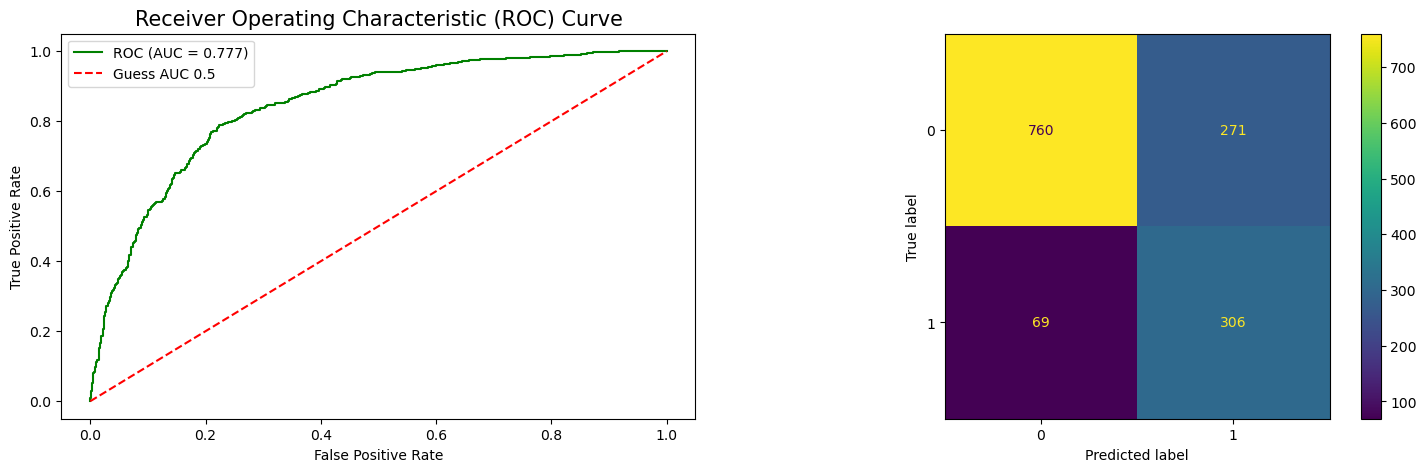

In [75]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)